In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import itertools
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from ete3 import TreeStyle, Tree


In [ ]:
# cluster_map = pd.read_csv('plotting_script/data/cluster_info.tsv', sep='\t')

# dle_info = pd.read_csv('plotting_script/data/protein_info.tsv', sep='\t')

# # display(cluster_map.head(), dle_info.head())

In [ ]:
# merged_df = dle_info.merge(cluster_map, on='Uniref', how='left')

# display(merged_df.head())


In [ ]:
# merged_df.drop(merged_df.columns[6], axis=1, inplace=True)
# merged_df.drop(merged_df.columns[6], axis=1, inplace=True)

# display(merged_df.head())



In [29]:
# merged_df.to_csv('plotting_script/data/merged_info.tsv', sep='\t', index=False)

In [2]:
merged_df = pd.read_csv('plotting_script/data/merged_info.tsv', sep='\t')

In [3]:
# Calculate the occurrence of each domain in each cluster
domain_occurrences = defaultdict(lambda: defaultdict(int))
total_domains_per_cluster = defaultdict(int)

for index, row in merged_df.iterrows():
    cluster_id = row['dl_endopeptidase-foldseek_cluster']
    domains = row['Interpro']
    
    if pd.notnull(domains):
        for domain in eval(domains):
            domain_occurrences[cluster_id][domain] += 1
            total_domains_per_cluster[cluster_id] += 1

# Calculate the percentage of each domain in each cluster
domain_percentages = {cluster: {domain: count / total_domains_per_cluster[cluster] 
                                for domain, count in domains.items()} 
                      for cluster, domains in domain_occurrences.items()}

# Convert domain percentages to a matrix for similarity calculation
# Create a list of all unique domains across all clusters
all_domains = set(domain for cluster_domains in domain_percentages.values() for domain in cluster_domains.keys())

# Create a matrix of domain percentages for each cluster
cluster_ids = list(domain_percentages.keys())
domain_matrix = np.zeros((len(cluster_ids), len(all_domains)))

# Mapping of cluster IDs and domain indices to facilitate matrix population
cluster_idx_map = {cluster_id: idx for idx, cluster_id in enumerate(cluster_ids)}
domain_idx_map = {domain: idx for idx, domain in enumerate(all_domains)}

# Populate the matrix with domain percentages
for cluster_id, domains in domain_percentages.items():
    for domain, percentage in domains.items():
        cluster_idx = cluster_idx_map[cluster_id]
        domain_idx = domain_idx_map[domain]
        domain_matrix[cluster_idx, domain_idx] = percentage

# Calculate cosine similarity between clusters based on domain matrix
cosine_sim = cosine_similarity(domain_matrix)

# Convert the similarity matrix to edge list for significant similarities
# We consider a similarity significant if it's above 0.1 (can adjust)
significant_similarity_threshold = 0.1
significant_edges = [(cluster_ids[i], cluster_ids[j], cosine_sim[i, j]) 
                     for i in range(len(cluster_ids)) 
                     for j in range(i+1, len(cluster_ids)) 
                     if cosine_sim[i, j] > significant_similarity_threshold]

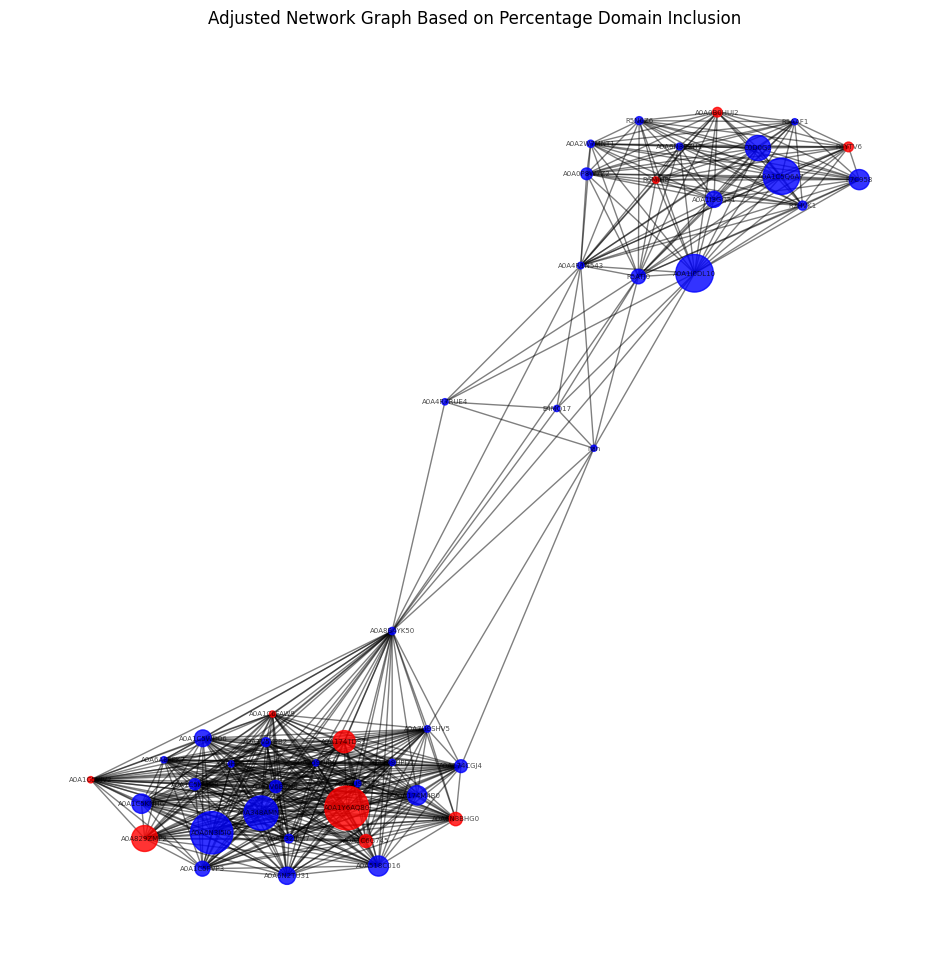

In [4]:
# Create the network graph based on adjusted domain similarity
G_adjusted_similarity = nx.Graph()

# Add nodes (clusters)
G_adjusted_similarity.add_nodes_from(cluster_ids)

# Add edges with weights based on cosine similarity
G_adjusted_similarity.add_weighted_edges_from(significant_edges)

downregulated_clusters = [
    "A0A1C6G745",
    "A0A829ZMP2",
    "A0A1C6FAW9",
    "A0A174TDS3",
    "R6MIH8",
    "A0A1C5VJV2",
    "A0A0B0HUJ2",
    "R6YTV6",
    "A0A1Y6AQ80",
    "A0A6N3BHG0"
]

# Assign colors to nodes based on whether they are downregulated in CRC
node_colors = ["red" if node in downregulated_clusters else "blue" for node in G_adjusted_similarity.nodes()]

# Step 1: Calculate the size of each cluster
cluster_sizes = merged_df['dl_endopeptidase-foldseek_cluster'].value_counts().to_dict()

# Step 2: Map cluster sizes to node sizes for visualization
# Normalize cluster sizes to a suitable range for node sizes in the graph (e.g., between 20 and 1000)
min_size = 20
max_size = 1000
min_cluster_size = min(cluster_sizes.values())
max_cluster_size = max(cluster_sizes.values())
node_sizes = [
    ((cluster_sizes[node] - min_cluster_size) / (max_cluster_size - min_cluster_size) * (max_size - min_size) + min_size)
    if node in cluster_sizes else min_size
    for node in G_adjusted_similarity.nodes()
]

# Visualize the adjusted network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_adjusted_similarity, seed=42)  # For consistent layout

# Draw the network
nx.draw_networkx_nodes(G_adjusted_similarity, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(G_adjusted_similarity, pos, alpha=0.5)
nx.draw_networkx_labels(G_adjusted_similarity, pos, font_size=5, alpha=0.7)

plt.title("Adjusted Network Graph Based on Percentage Domain Inclusion")
plt.axis('off')
plt.savefig('../../figures/adjusted_network.png', dpi=600, bbox_inches='tight')

In [3]:
# Extract Lineage and Cluster columns
lineage_cluster_data = merged_df[['Lineage', 'dl_endopeptidase-foldseek_cluster']]

display(lineage_cluster_data.head(), lineage_cluster_data.shape)

,Lineage,dl_endopeptidase-foldseek_cluster
0,d__Bacteria;p__Firmicutes;c__Bacilli;o__RFN20;...,A0A1C5WD06
1,d__Bacteria;p__Firmicutes;c__Bacilli;o__RFN20;...,A0A1C5WD06
2,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,A0A1V6BVN9
3,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,A0A1V5YPB2
4,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,A0A1V6BVN9


(75556, 2)

In [4]:
lineages = lineage_cluster_data['Lineage'].apply(lambda x: x.split('; '))

In [5]:
# Initialize an empty Tree
t = Tree()
# Dictionary to keep track of already added nodes
node_dict = {}

for lineage in lineages:
    current_node = t
    for taxon in lineage:
        if taxon not in node_dict:
            # If the taxon is new, add it as a child to the current node and update the current node
            child = current_node.add_child(name=taxon)
            node_dict[taxon] = child
            current_node = child
        else:
            # If the taxon already exists, move to the node representing this taxon
            current_node = node_dict[taxon]

In [6]:

ts = TreeStyle()
ts.show_leaf_name = False
# ts.scale =  120  # Adjust scale to fit your tree's size
t.show(tree_style=ts)


In [3]:


# Initialize an empty Tree
t = Tree()
# Dictionary to keep track of already added nodes
node_dict = {}

for index, row in merged_df.iterrows():
    # Split the taxonomic information into parts
    lineage = row['Lineage'].split(';')
    current_node = t
    for taxon in lineage:
        if taxon not in node_dict:
            # If the taxon is new, add it as a child to the current node and update the current node
            child = current_node.add_child(name=taxon)
            node_dict[taxon] = child
            current_node = child
        else:
            # If the taxon already exists, move to the node representing this taxon
            current_node = node_dict[taxon]

# At this point, you have the tree structure in `t`. You need to convert it to Newick format.
newick_str = t.write(format=1)
print(newick_str)

(((((((s__UBA733 sp900767605:1)g__UBA733:1)f__CAG-826:1)o__RFN20:1,(((s__Bacillus_A paranthracis:1,s__Bacillus_A luti:1,s__Bacillus_A thuringiensis_S:1,s__Bacillus_A wiedmannii:1)g__Bacillus_A:1)f__Bacillaceae_G:1,((s__Bacillus paralicheniformis:1,s__Bacillus sonorensis:1,s__Bacillus licheniformis:1,s__Bacillus subtilis:1)g__Bacillus:1)f__Bacillaceae:1)o__Bacillales:1,(((s__Enterococcus_B faecium:1,s__Enterococcus_B lactis:1,s__Enterococcus_B durans:1)g__Enterococcus_B:1,(s__Enterococcus faecalis:1)g__Enterococcus:1,(s__Enterococcus_A avium:1,s__Enterococcus_A raffinosus:1)g__Enterococcus_A:1,(s__Enterococcus_D sp002850555:1,s__Enterococcus_D casseliflavus:1,s__Enterococcus_D gallinarum:1)g__Enterococcus_D:1,(s__Enterococcus_C dispar:1)g__Enterococcus_C:1)f__Enterococcaceae:1,((s__Lactiplantibacillus plantarum:1,s__Lactiplantibacillus pentosus:1)g__Lactiplantibacillus:1,(s__Limosilactobacillus mucosae:1,s__Limosilactobacillus reuteri_E:1)g__Limosilactobacillus:1,(s__Lentilactobacillus 